# Table of Contents
#### Preface
#### Progress Updates
#### Analysis
    - Making the Scoring System
#### Critiques/Possible Improvements
#### Current Plans

# Preface
In this notebook, I will try to create a scoring mechanism that rates the severity of expoits that are collected in a CVE project.  

The main goals I have for this project are:

1. Learn about and gain experience using Python for basic data analysis
2. Learn a little bit more about security concepts related to CVEs
3. Show my basic problem solving approach

For goal 3, a lot of writing in this notebook will consist of my internal thought process in order to show what I am trying to do and what I aim to do going forward.

# Progress Updates

- 11/9/2020 through 11/13/2020: Started working on the notebook. Added Preface and Analysis. Analysis done only up to the point where terminology was defined for my sake. Most of this week was spent looking up documentation and watching Python videos
- 11/16/2020 through 11/27/2020: Completed the task of making a CVE scoring mechanisms. Added Critiques/Possible Improvements and Current Plans section

# Analysis

In [1]:
# import pandas and numpy to work on data given
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read jsons
exploits_df = pd.read_json('C:\\Users\\beton\\Documents\\CVE_Analysis\\exploits.json', orient='split')
metadata_df = pd.read_json('C:\\Users\\beton\\Documents\\CVE_Analysis\\metadata.json', orient='split')
products_df = pd.read_json('C:\\Users\\beton\\Documents\\CVE_Analysis\\products.json', orient='split')

First, I'll take a look at what kind of data is contained in each json:

In [3]:
exploits_df.head(n=3)

,cve,uri,publish_date
0,CVE-2019-8664,https://packetstormsecurity.com/files/153531/i...,2019-07-04 14:34:02+00:00
1,CVE-2019-8718,https://packetstormsecurity.com/files/155221,2020-03-30 13:29:20
2,CVE-2019-8718,https://www.exploit-db.com/exploits/47607,2019-11-11 00:00:00


In [4]:
exploits_df.describe()

,cve,uri,publish_date
count,7112,7112,7090
unique,3432,4842,4732
top,CVE-2019-19781,https://www.tenable.com/blog/critical-vulnerab...,2019-06-07 15:06:02+00:00
freq,25,121,47


In the **exploits json**, the data consists of the CVE, the URI, and the publish date. Some CVEs have multiple URIs with different publish dates. Neither the URI nor the publish date here seem particularly useful for a basic exploit scoring mechanism. The publish date could possibly be analyzed to see if there are any correlations between the date an expoit was published with other expoit metrics, but that is beyond what I am trying to do at the moment.  

In [5]:
metadata_df.head(n=3)

,cve,property,value
0,CVE-2019-3396,type,Thing
1,CVE-2019-3396,type,CVE
2,CVE-2019-3396,type,Vulnerability


In [6]:
metadata_df.describe()

,cve,property,value
count,1671006,1671006,1671006
unique,37279,45,206753
top,CVE-2019-1748,references,CVSS_Severity_Medium
freq,973,223286,49788


In [7]:
metadata_df["property"].value_counts()

references                        223286
type                              215168
exposes_vulnerability_in          169546
has_metric                         68870
has_confidentiality_impact         61825
has_integrity_impact               58400
has_availability_impact            54830
label                              37280
ID                                 37279
Summary                            37279
Published                          37279
affects_cpe                        37279
Updated                            37279
CVSSv2_Base_Score                  34448
has_severity_cvssv2                34448
has_access_complexity              34448
has_access_vector                  34448
has_authentication                 34448
has_metric_cvssv2                  34448
has_metric_cvssv3                  34422
CVSSv3_Base_Score                  34422
has_severity_cvssv3                34422
has_severity                       34422
CVSSv3_Exploitability_Score        34422
CVSSv3_Impact_Sc

In the **metadata json**, the data consists of the CVE, a specific property, and the corresponding value for the property. A single CVE can have many different properties with corresponding values. This data seeems like it will be especially important for scoring exploits, and I will need to do  some research on the different properties in the data. I will also have to eventually reorganize this data for scoring purposes later on. 

In [8]:
products_df.head(n=3)

,cve,vendor,product,version
0,CVE-2020-8579,Netapp,Clustered_Data_Ontap,9.7
1,CVE-2020-8579,Netapp,Clustered_Data_Ontap,9.7
2,CVE-2020-8579,Netapp,Clustered_Data_Ontap,9.7


In [9]:
products_df.describe()

,cve,vendor,product,version
count,170230,170230,170230,170230
unique,34445,5198,19595,7873
top,CVE-2019-1748,Microsoft,Junos,any
freq,931,21257,10406,45623


In the **products json**, the data consists of the CVE, the specific products it affects as well as the corresponding vendors and affected product versions of the affected products. What will most likely be important from this data is both the number of CVEs that affect a given product as well whether or not the exploits affect multiple product versions of each product. 

### Terminology/Concepts to know

To get a better understanding of CVE properties and security context in general, I will need to look up some of the terminology in the metadata json for property values. I'll make a list of the terms here containing a condensed definition of each term and my understanding of their relevance to what I am trying to do:

>1. **CVE** - Stands for Common Vulnerability and Exposures. Reference system for security vulnerabilities
2. **CVSS** - Stands for Common Vulnerability Scoring System. Industry standard scoring metric that asseses the severity of computer security vulnerabilities. Consists of base score, temporal score, and environmental score metrics. The most current version of the system is v3.1
3. **CVSSv3 Base Score** - Metric that is based on the baseline qualities of vulnerabilities. Consists of attack vector, attack complexity, privileges required, user interaction, scope, confidentiality impact, integrity impact, and availability impact. **The base score will most definitely be used as a component for the scoring mechanism**
4. **CVSSv3 Temporal Score** - Metric that is based on the vulnerability characteristics that can change over time. Consists of exploit code maturity, remediation level, and report confidence. Since the CVE data doesn't contain temporal score as far as I can tell, I won't be using this as part of my scoring system. Of course, if the data was available, I would most likely use it together with the other CVSS metrics
5. **CVSSv3 Environmental Score** - Metric that uses the base and temporal scores in the context of varying implemenatations/environments. Has 2 main submetrics which are exploitability metrics and impact metrics in addition to an impact subscore modifier. Just like the temporal score, the environmental score is not available in the data set, so I cannot use it for my scoring system.
6. **CVSS Attack Vector** - Metric that shows how a vulnerability may be exploited. Can be local, adjacent network, or network. Although it is only a single factor used to determine base score, as mentioned in the assignment pdf, **network attack vector exploits are particularly important**  since Trend Micro primarily focuses on network security.
7. **Microsoft Severity Rating System** - A system much like CVSS but specifically for Microsoft products. Is designed to help Microsoft customers understand how critical certain product updates may be. Although only a relatively small portion of the exploits in the CVE data seem to have a Microsoft severity rating, **they are likely important due to how often Microsoft products are used by consumers**.


### CVE Analysis 1: Making the scoring system

In the CVE data, there are a mix of CVEs that contain either a CVSSv2 or a CVSSv3 base score or both. For the sake of consistency and using the most up-to-date values, I will only use CVSSv3 scores as part of the scoring system.

In [10]:
# Filter out CVEs that have a CVSSv3 score from the metadata dataframe and make a list out of them 

scored_cves = metadata_df[metadata_df['property']=='CVSSv3_Base_Score']

# check that every cve in the list is unique
scored_cves.describe()

,cve,property,value
count,34422,34422,34422.0
unique,34422,1,78.0
top,CVE-2020-7820,CVSSv3_Base_Score,9.8
freq,1,34422,4466.0


In [11]:
# sort cves by cve ID number (not particularly necessary but just for organization)
cves = scored_cves.sort_values(by='cve')

# reset index of dataframe, drop the property label, and rename score column
cves.reset_index(drop=True, inplace=True)
cves.drop(columns='property', inplace=True)
cves.rename(columns = {'value': 'CVSSv3 Base Score'}, inplace=True)
cves

,cve,CVSSv3 Base Score
0,CVE-1999-0199,9.8
1,CVE-2002-2439,7.8
2,CVE-2002-2444,9.8
3,CVE-2004-2776,9.8
4,CVE-2005-2349,7.5
...,...,...
34417,CVE-2020-9985,7.8
34418,CVE-2020-9986,3.3
34419,CVE-2020-9992,7.8
34420,CVE-2020-9994,7.1


This dataframe will be the main dataframe I will use to contain all of the metrics that go into the scoring system. I will need to add the other metrics I would like use to this dataframe (the metrics used are subject to change based on any feedback I get). Other metrics I would like to use include  
1. Attack vector  
2. Number of products affected  
3. ~~Number of updates~~ (metadata only shows the most recent update date; can't count total updates)  
4. Number of publicly known exploits per CVE  
5. Which CVEs affect products that are affected by many other CVEs  

#### *Getting Attack Vector Metrics*

In [12]:
# First, I'll start off with the attack vector value for each CVE

# add empty column into dataframe which will be filled with attack vector data
cves['Access Vector']=' '

# trim metadata to only rows that contain access vector data
vectors_df = metadata_df[metadata_df['property']== 'has_access_vector'].set_index('cve')
insert_index = 0

# take access vector value from metadata and insert it into corresponding cve dataframe location
# account for missing values with exceptions
for i in cves['cve']:
    try:
        cves.at[insert_index, 'Access Vector'] = vectors_df.at[i,'value']
    except:
        cves.at[insert_index, 'Access Vector'] = np.NaN
    insert_index += 1

In [13]:
cves

,cve,CVSSv3 Base Score,Access Vector
0,CVE-1999-0199,9.8,CVSS_Access_Vector_Network
1,CVE-2002-2439,7.8,CVSS_Access_Vector_Local
2,CVE-2002-2444,9.8,CVSS_Access_Vector_Network
3,CVE-2004-2776,9.8,CVSS_Access_Vector_Network
4,CVE-2005-2349,7.5,CVSS_Access_Vector_Network
...,...,...,...
34417,CVE-2020-9985,7.8,CVSS_Access_Vector_Network
34418,CVE-2020-9986,3.3,CVSS_Access_Vector_Network
34419,CVE-2020-9992,7.8,CVSS_Access_Vector_Network
34420,CVE-2020-9994,7.1,CVSS_Access_Vector_Network


The updated dataframe looks good, but I need to check to see if there were missing access vector values.

In [14]:
cves['Access Vector'].isnull().sum()

13

It looks like there were a few missing values. Luckily, I can fill them in using the 'has_metric' property, which contains the full CVSS component values that go into the base score, including the access vector. However, **since the amount of cves that were missing an access vector value is quite small, I will go back to this later to fill in the data since I would prefer getting the large chunks of data organized first**


#### *Getting Number of Products affected*
Since the products data does not explicitly give the number of products a single cve affects, I will have to find a way to count the number of affected products per cve using another method. I will do this by using the groupby() and nunique() pandas functions

In [15]:
# get a dataframe with the number of unique products affected by each cve
product_counts = products_df.groupby('cve').product.nunique().to_frame(name='count')

# check if data looks alright
product_counts.head(n=10)

,count
cve,
CVE-1999-0199,1
CVE-2002-2439,1
CVE-2002-2444,1
CVE-2004-2776,1
CVE-2005-2349,1
CVE-2005-2350,1
CVE-2005-2351,2
CVE-2005-2352,1
CVE-2005-2354,1


In [16]:
# add empty column into dataframe which will be filled with product count
cves['Products_Affected']=' '

# insert product counts into cve datafram for only the cves actually listed in the dataframe
insert_index = 0
for i in cves['cve']:
    try:
        cves.at[insert_index, 'Products_Affected'] = product_counts.at[i,'count']
    except:
        cves.at[insert_index, 'Products_Affected'] = 0
    insert_index += 1
cves.head(n=10)

,cve,CVSSv3 Base Score,Access Vector,Products_Affected
0,CVE-1999-0199,9.8,CVSS_Access_Vector_Network,1
1,CVE-2002-2439,7.8,CVSS_Access_Vector_Local,1
2,CVE-2002-2444,9.8,CVSS_Access_Vector_Network,1
3,CVE-2004-2776,9.8,CVSS_Access_Vector_Network,1
4,CVE-2005-2349,7.5,CVSS_Access_Vector_Network,1
5,CVE-2005-2350,6.1,CVSS_Access_Vector_Network,1
6,CVE-2005-2351,5.5,CVSS_Access_Vector_Local,2
7,CVE-2005-2352,8.1,CVSS_Access_Vector_Network,1
8,CVE-2005-2354,9.8,CVSS_Access_Vector_Network,1
9,CVE-2005-3056,9.8,CVSS_Access_Vector_Network,1


#### *Getting Number of Exploits*

In [17]:
# get a dataframe with the all of the CVEs that have known exploits
cve_exploits = metadata_df[metadata_df['property'] == 'exploited_by']
cve_exploits

,cve,property,value
31,CVE-2019-3396,exploited_by,_08618d860b74089f34ed5aa1686ddc0e
32,CVE-2019-3396,exploited_by,EDB-46731
33,CVE-2019-3396,exploited_by,_1ac7df0b1c8c99deadd1a5c98c73ee43
34,CVE-2019-3396,exploited_by,_171417ace7bc92f50132945b5dbb38b0
35,CVE-2019-3396,exploited_by,_3a579995c0a0e29f759a2c6f801a7b7d
...,...,...,...
1664144,CVE-2020-15906,exploited_by,EDB-48927
1666230,CVE-2018-8062,exploited_by,_99693ea21a7812a1b6b495097c1f194f
1666231,CVE-2018-8062,exploited_by,EDB-48908
1669147,CVE-2020-15238,exploited_by,EDB-48963


In [18]:
# count freqeuncy of exploits
exploit_count = cve_exploits["cve"].value_counts().to_frame()
exploit_count.rename(columns = {'cve': 'count'}, inplace=True)
exploit_count

,count
CVE-2019-19781,27
CVE-2020-0796,25
CVE-2019-0708,23
CVE-2019-16759,23
CVE-2020-5902,22
...,...
CVE-2020-3247,1
CVE-2019-3915,1
CVE-2020-12696,1
CVE-2018-7123,1


In [19]:
# add empty column into dataframe which will be filled with exploit count
cves['Exploit_Count']=' '

# insert exploit counts into cve dataframe for only the cves actually listed in the dataframe
insert_index = 0
for i in cves['cve']:
    try:
        cves.at[insert_index, 'Exploit_Count'] = exploit_count.at[i,'count']
    except:
        cves.at[insert_index, 'Exploit_Count'] = 0
    insert_index += 1

In [20]:
# check cves dataframe
cves

,cve,CVSSv3 Base Score,Access Vector,Products_Affected,Exploit_Count
0,CVE-1999-0199,9.8,CVSS_Access_Vector_Network,1,0
1,CVE-2002-2439,7.8,CVSS_Access_Vector_Local,1,0
2,CVE-2002-2444,9.8,CVSS_Access_Vector_Network,1,0
3,CVE-2004-2776,9.8,CVSS_Access_Vector_Network,1,0
4,CVE-2005-2349,7.5,CVSS_Access_Vector_Network,1,0
...,...,...,...,...,...
34417,CVE-2020-9985,7.8,CVSS_Access_Vector_Network,4,0
34418,CVE-2020-9986,3.3,CVSS_Access_Vector_Network,1,0
34419,CVE-2020-9992,7.8,CVSS_Access_Vector_Network,3,0
34420,CVE-2020-9994,7.1,CVSS_Access_Vector_Network,5,0


#### *Getting Exploit Count Per Product*

In [41]:
# make a new dataframe with data from the products dataframe
product_exploits = products_df['cve'].to_frame()
product_exploits['product'] = products_df['product']
product_exploits['id'] = products_df['cve'] + products_df['vendor'] + ':' + products_df['product'] # concatenate cve, vendor, product, and version to count unique exploits per product while accounting for possible duplicates
product_exploits.drop_duplicates(subset=['id'], inplace=True)

# count the number of exploits a single product has
product_exploit_count = product_exploits.value_counts(['product']).to_frame(name='count')


# make a new column in product_exploits dataframe to add the per product exploit count
product_exploits['overlap'] = ' '
for index, row in product_exploits.iterrows():
    try:
        row['overlap'] = int(product_exploit_count.at[row['product'],'count'])
    except:
        row['overlap'] = 0
product_exploits.sort_values(by=['overlap'], ascending=False)

,cve,product,id,overlap
9782,CVE-2020-0279,Android,CVE-2020-0279Google:Android,1413
9751,CVE-2020-0379,Android,CVE-2020-0379Google:Android,1413
107542,CVE-2019-9235,Android,CVE-2019-9235Google:Android,1413
107541,CVE-2019-9234,Android,CVE-2019-9234Google:Android,1413
107540,CVE-2019-9233,Android,CVE-2019-9233Google:Android,1413
...,...,...,...,...
18587,CVE-2020-12300,S2600Kptr_Firmware,CVE-2020-12300Intel:S2600Kptr_Firmware,1
18586,CVE-2020-12300,S2600Kpr_Firmware,CVE-2020-12300Intel:S2600Kpr_Firmware,1
18585,CVE-2020-12300,S2600Kpfr_Firmware,CVE-2020-12300Intel:S2600Kpfr_Firmware,1
18584,CVE-2020-12300,S2600Kpf_Firmware,CVE-2020-12300Intel:S2600Kpf_Firmware,1


In [22]:
# get the total value of exploits that have a shared product affected
product_exploits_dropped = product_exploits.drop(['product', 'id'], axis = 1) 
overlap = product_exploits_dropped.groupby(['cve']).sum()

In [23]:
# add overlap to main cve dataframe
cves['Product_Exploit_Overlap']=' '

# insert overlap counts into cve dataframe
insert_index = 0
for i in cves['cve']:
    try:
        cves.at[insert_index, 'Product_Exploit_Overlap'] = overlap.at[i,'overlap']
    except:
        cves.at[insert_index, 'Product_Exploit_Overlap'] = 0
    insert_index += 1

In [24]:
# check cves dataframe
cves

,cve,CVSSv3 Base Score,Access Vector,Products_Affected,Exploit_Count,Product_Exploit_Overlap
0,CVE-1999-0199,9.8,CVSS_Access_Vector_Network,1,0,20
1,CVE-2002-2439,7.8,CVSS_Access_Vector_Local,1,0,3
2,CVE-2002-2444,9.8,CVSS_Access_Vector_Network,1,0,1
3,CVE-2004-2776,9.8,CVSS_Access_Vector_Network,1,0,1
4,CVE-2005-2349,7.5,CVSS_Access_Vector_Network,1,0,1
...,...,...,...,...,...,...
34417,CVE-2020-9985,7.8,CVSS_Access_Vector_Network,4,0,1430
34418,CVE-2020-9986,3.3,CVSS_Access_Vector_Network,1,0,473
34419,CVE-2020-9992,7.8,CVSS_Access_Vector_Network,3,0,658
34420,CVE-2020-9994,7.1,CVSS_Access_Vector_Network,5,0,1809


#### Scoring the CVEs

At this point, I feel like there are enough metrics to start scoring the CVEs, so now I have to determine how I'd like to weigh each metric in making the final score.

**One important thing to note is that the scoring itself is arbitrary, especially due to the fact that I do not have enough experience/knowledge regarding cybersecurity to properly gauge how severe/important a CVE is based on the metrics compiled. Also, the metrics I compiled may not necessarily be helpful in making a practical and accurate assessment of CVE importance**

I'd like to make each metric contribute up to a certain percentage of the final score, with the more signifant metrics making up a larger percentage. Since the actual number for the final score is arbitrary, I'll make it out of 100 for simplicity.

Metric percentages:

- CVSSv3 Base Score - 30%: Since the CVSS score is an industry standard rating based on many common vulnerability metrics, I want to give the largest percentage and use it as the foundation for building the rest of the final score
- Access Vector - 25%: Since the access vector is particularly important in the case of network access vectors, the access vector will have the second largest percentage of the score
- Products Affected - 15%
- Exploit Count - 15%
- Product Exploit Overlap: 15%

Since the CVSS base score is already a score out of 10, I only need to rescale the score values to be out of 30.  

As for the rest of the metrics I will need to first take a look at the values present for the metrics.

In [25]:
cves.describe()

,cve,CVSSv3 Base Score,Access Vector,Products_Affected,Exploit_Count,Product_Exploit_Overlap
count,34422,34422.0,34409,34422,34422,34422
unique,34422,78.0,3,114,26,1599
top,CVE-2020-7820,9.8,CVSS_Access_Vector_Network,1,0,1
freq,1,4466.0,27575,24745,31028,4385


In [26]:
max(cves['Products_Affected'])

444

In [27]:
max(cves['Exploit_Count'])

27

In [28]:
max(cves['Product_Exploit_Overlap'])

12037

**Access vector weighting:**
There are 3 categories of access vectors present in the compiled data: network, adjacent network, and local. Of these, network access vectors are the most important while local ones are the least (in the context of what Trend Micro would focus on). Thus, I'll have the scoring such that:

- Network: 25%
- Adjacent Network: 15%
- Local: 0%

**Products affected weighting:**
From the data analysis, the maximum number of products a single CVE was found to affect was 444. One simple way to do this would be to simply rescale the metric values linearly such that 440 becomes 15% and 0 is 0%. However, I think it would be worth looking at the data distribution of products affected first.

<AxesSubplot:xlabel='Products_Affected'>

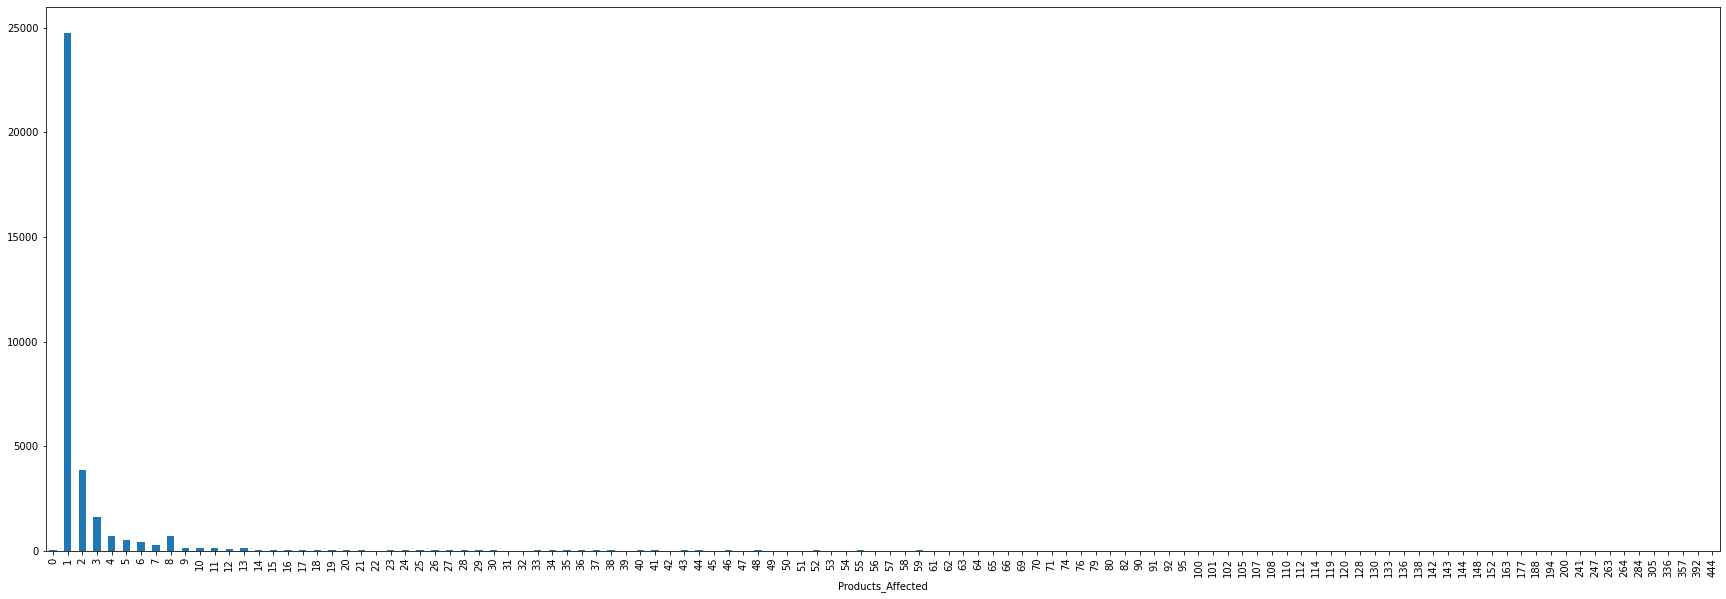

In [29]:
# plot the data frequency distribution
cves.groupby('Products_Affected').size().plot.bar(figsize=(30,10))

<AxesSubplot:>

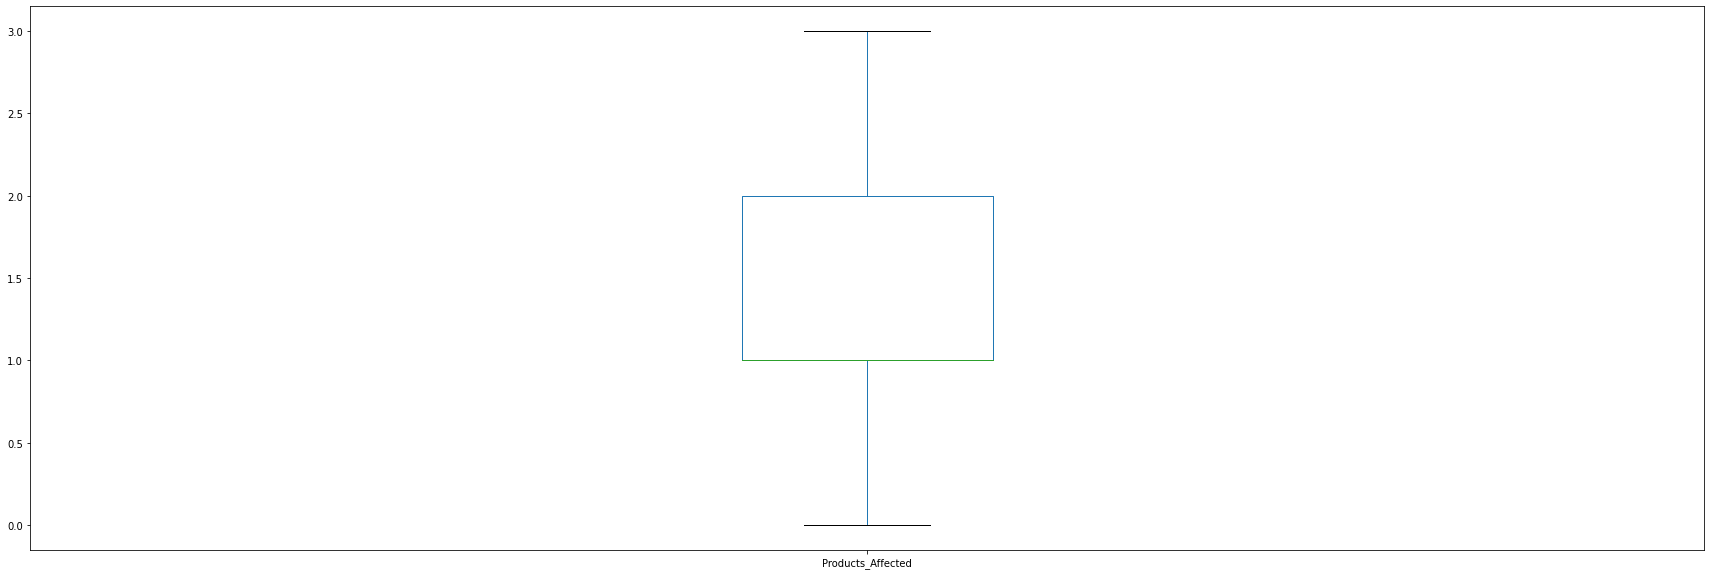

In [30]:
cves['Products_Affected'].to_frame().plot.box(figsize=(30,10), showfliers=False)

**Products affected (continued)**

Looking at the distribution of products affected per CVE, a vast majority of CVEs only affect a single product to begin with. At least 75 percent of the CVEs only affect 2 or less products With that in mind, using a linear rescaling from 0 to 440 does not seem like it would a very good method of scoring. Since the distributions seem to fit an exponential curve, I could  rescale the frequency values using their log values. Or, I could take some reasonable maximum value, like 20 or 30, and make it such that any CVE with products affected count that is higher than that max will get the full 15% and any counts that are lower than that max will be scored using a linear (or logarithmic) scale.

If I were to do the maximum value + linear scale, the scoring would go like this:

- If a CVE has a products affected count greater than or equal to z, the CVE gets the full 15% of the weighted score
- Else the CVE will have a scaled weighted score using the equation:

>y = (15/max)*x  

where y is the weighted score, max is the selected maximum value for products affected counts, and x is the actual number of products affected for a given CVE

- Using 20 as the max value, the equation would become:

>y = (3/4)*x

**Exploit count weighting :**  

The maximum number of exploits found for any single CVE was found to be 27. Compared to the products affected metric, the range of the values to be rescaled isn't as large, so a linear rescaling of 0 to 27 may work fine. I will still check the distribution of exploit counts anyway.

<AxesSubplot:xlabel='Exploit_Count'>

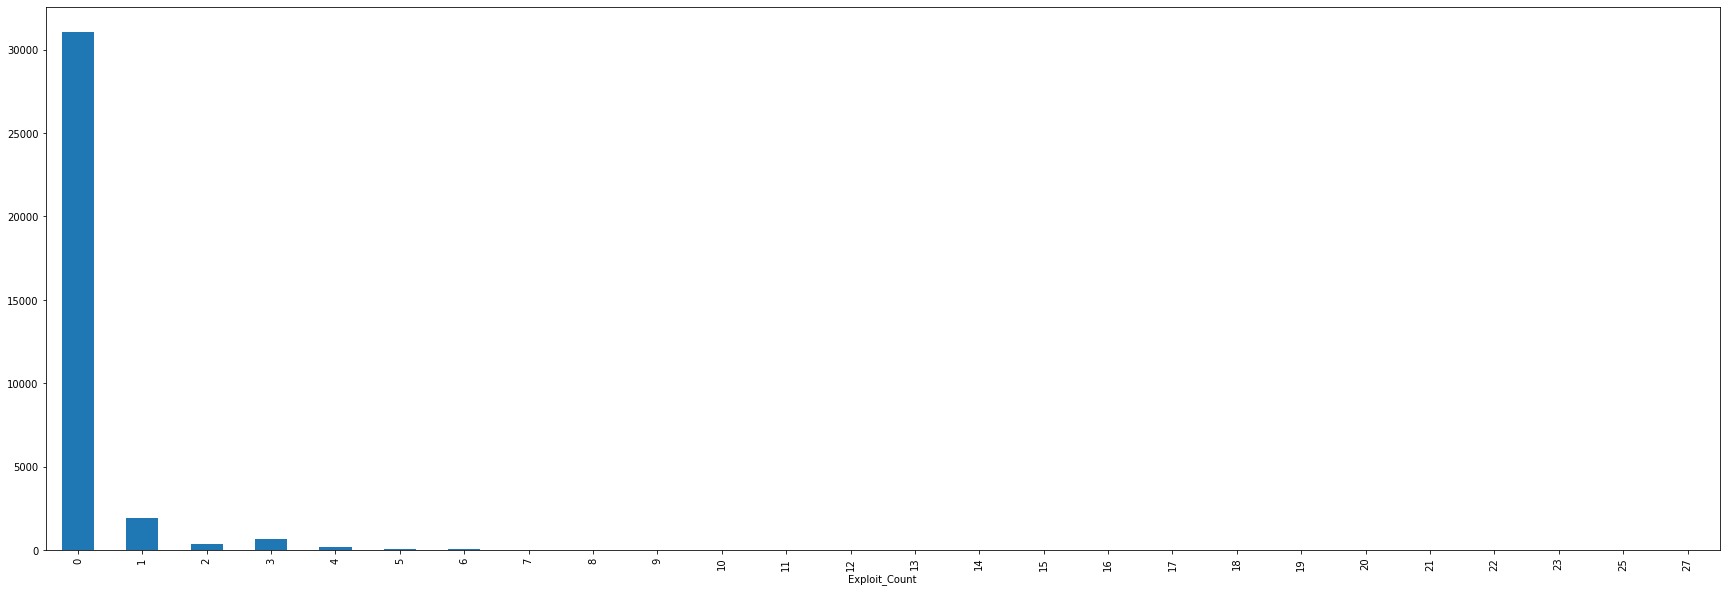

In [31]:
# get the data distribution then plot it
cves.groupby('Exploit_Count').size().plot.bar(figsize=(30,10))

<AxesSubplot:>

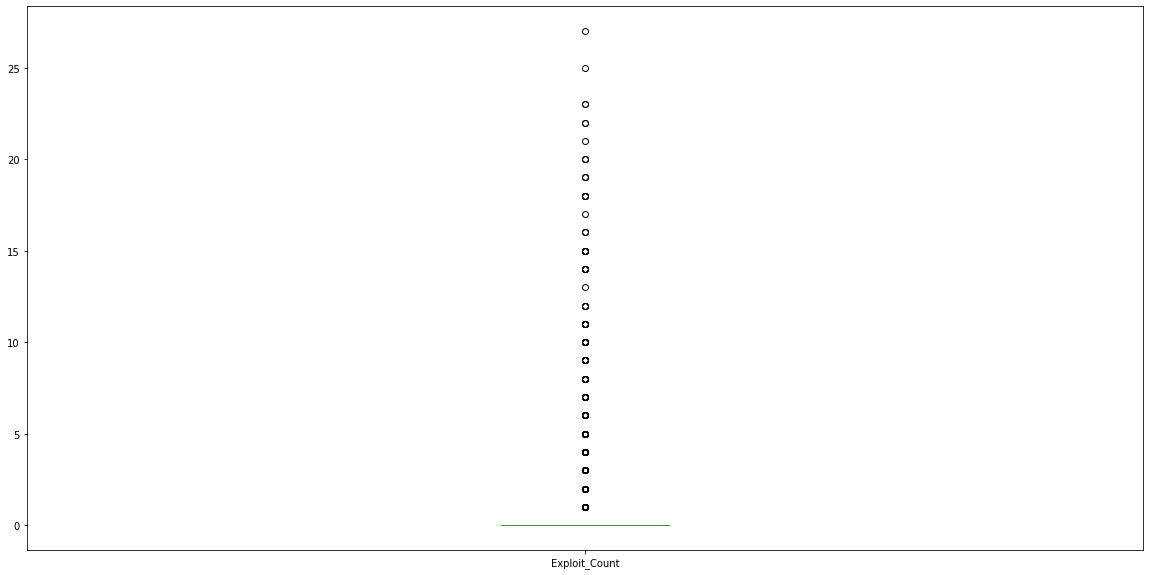

In [32]:
cves['Exploit_Count'].to_frame().plot.box(figsize=(20,10))

**Exploit count (continued):**

Similar to the products affected distribution, the distribution of known exploit counts is heavily focused in a single value (0 in this case). I'll do the same system of a maximum value and a linear rescale for values underneath it.

Scoring then becomes:

- If a CVE has more than 5 known exploits, it will get the full 15% weighted score
- Else, the weighted score will be calculated using the equation:

>y = 3*x  

where y is the weighted score and x is the exploit count for the CVE

**CVE overlap weighting :**  

Like the previous metrics, I'll first look at the data distribution of this metric.

In [33]:
cves['Product_Exploit_Overlap'].value_counts().to_frame()

,Product_Exploit_Overlap
1,4385
2,2586
3,1738
1413,1400
4,1334
...,...
1871,1
1876,1
1878,1
1886,1


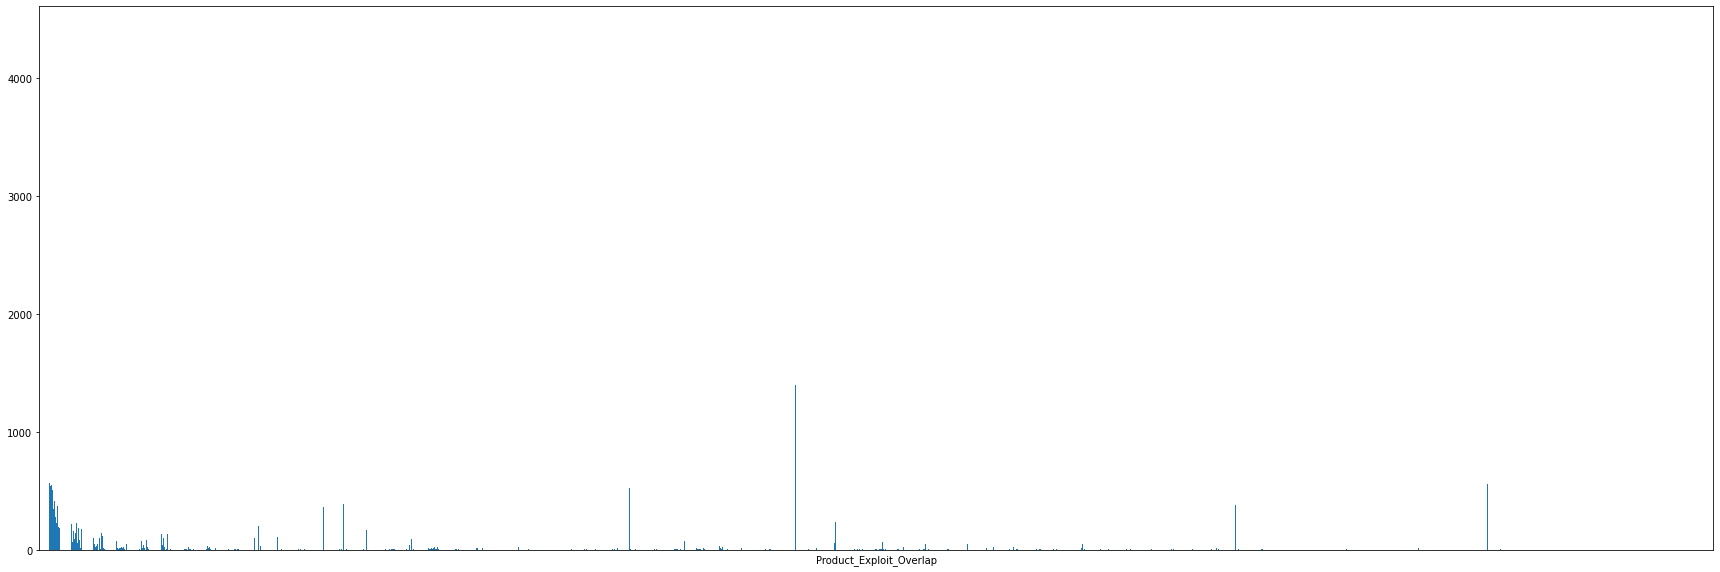

In [34]:
cves.groupby('Product_Exploit_Overlap').size().plot.bar(figsize=(30,10))
plt.tick_params(
    axis='x',         
    which='both',    
    bottom=False,     
    top=False,       
    labelbottom=False)

<AxesSubplot:>

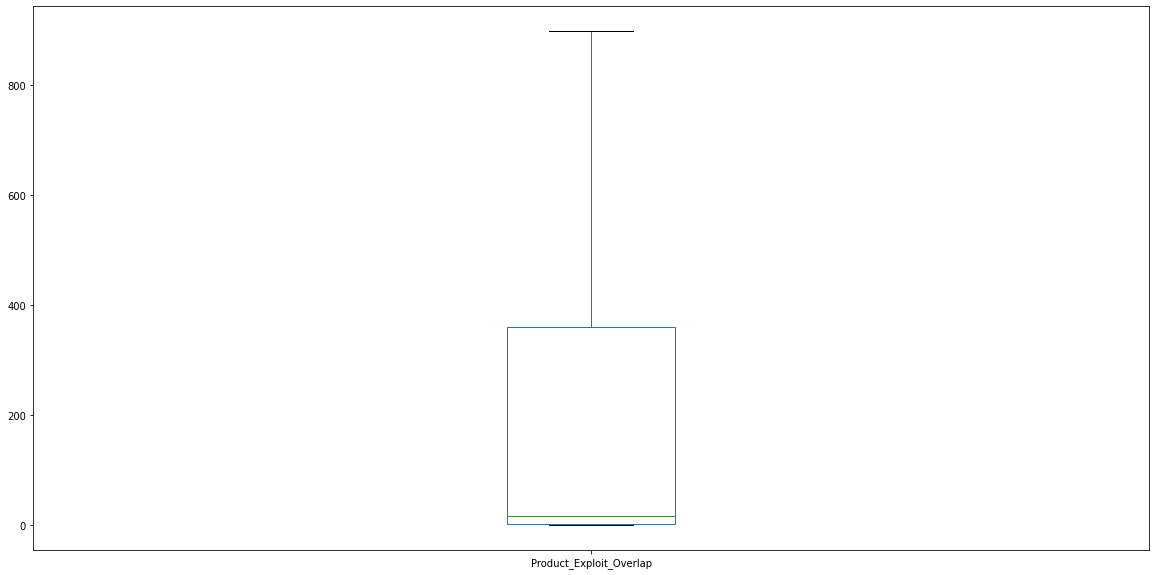

In [35]:
cves['Product_Exploit_Overlap'].to_frame().plot.box(figsize=(20,10), showfliers=False)

**CVE overlap (continued) :**

For this metric, the frequency of metric values are more all over the place, but most values are under 400 so I will use 400 as the maximum value.

Scoring then becomes:

- If a CVE has more than 400 known exploits, it will get the full 15% weighted score
- Else, the weighted score will be calculated using the equation:

>y = (15/400)*x  

where y is the weighted score and x is the exploit overlap count for the CVE

Now it is time to actually apply the scoring mechanisms to the data.

In [36]:
# make a new column for the final weighted score
cves['Rating_Score'] = ' '

In [37]:
cves

,cve,CVSSv3 Base Score,Access Vector,Products_Affected,Exploit_Count,Product_Exploit_Overlap,Rating_Score
0,CVE-1999-0199,9.8,CVSS_Access_Vector_Network,1,0,20,
1,CVE-2002-2439,7.8,CVSS_Access_Vector_Local,1,0,3,
2,CVE-2002-2444,9.8,CVSS_Access_Vector_Network,1,0,1,
3,CVE-2004-2776,9.8,CVSS_Access_Vector_Network,1,0,1,
4,CVE-2005-2349,7.5,CVSS_Access_Vector_Network,1,0,1,
...,...,...,...,...,...,...,...
34417,CVE-2020-9985,7.8,CVSS_Access_Vector_Network,4,0,1430,
34418,CVE-2020-9986,3.3,CVSS_Access_Vector_Network,1,0,473,
34419,CVE-2020-9992,7.8,CVSS_Access_Vector_Network,3,0,658,
34420,CVE-2020-9994,7.1,CVSS_Access_Vector_Network,5,0,1809,


In [38]:
# iterate through the CVE dataframe rows to calculate the weighted score of each CVE
for index, row in cves.iterrows():
    # base score
    score1 = row['CVSSv3 Base Score']*3
    
    # access vector score
    if row['Access Vector'] == 'CVSS_Access_Vector_Network':
        score2 = 25
    elif row['Access Vector'] == 'CVSS_Access_Vector_Adjacent_Network':
        score2 = 15
    else:
        score2 = 0
        
    # products affected score
    if row['Products_Affected'] >= 20:
        score3 = 15
    else:
        score3 = (3/4)*row['Products_Affected']
        
    # exploit count score
    if row['Exploit_Count'] >= 5:
        score4 = 15
    else:
        score4 = 3*row['Exploit_Count']
        
    # exploit overlap score
    if row['Product_Exploit_Overlap'] >= 400:
        score5 = 15
    else:
        score5 = (15/400)*row['Product_Exploit_Overlap']
        
    # sum total score
    row['Rating_Score'] = score1 + score2 + score3 + score4

Now I'll check to see if scores were tallied properly:

In [39]:
cves.sort_values(by='Rating_Score', ascending=False)

,cve,CVSSv3 Base Score,Access Vector,Products_Affected,Exploit_Count,Product_Exploit_Overlap,Rating_Score
33780,CVE-2020-9054,9.8,CVSS_Access_Vector_Network,26,4,65,81.4
31811,CVE-2020-5902,9.8,CVSS_Access_Vector_Network,14,22,1605,79.9
20080,CVE-2019-5736,8.6,CVSS_Access_Vector_Network,18,15,2346,79.3
18979,CVE-2019-3929,9.8,CVSS_Access_Vector_Network,12,7,50,78.4
27128,CVE-2020-1472,10,CVSS_Access_Vector_Network,9,5,5430,76.75
...,...,...,...,...,...,...,...
18514,CVE-2019-2940,2.3,CVSS_Access_Vector_Local,1,0,35,7.65
28200,CVE-2020-16241,2.1,CVSS_Access_Vector_Local,1,0,3,7.05
28197,CVE-2020-16237,2.1,CVSS_Access_Vector_Local,1,0,3,7.05
2991,CVE-2017-2752,2.1,CVSS_Access_Vector_Local,1,0,1,7.05


Now I have a list of CVEs with a rating score applied to them based on the metrics taken. Of the CVEs, the highest scoring CVE had a score of 81.4 while the lowest had a score of 6.15.

# Critiques/Possible Improvements

Some things that I'd like to note:

1. **The code used is inefficient**
    - I'm not a programmer, and it's been a while since I last formally studied anything coding-related as a student. Because of that, there are without at doubt many improvements that could be made with how I retrieved, organized, and processed the data provided to me.
2. **Some of the things done here could have been made easier by using SQL**
    - I definitely could have sorted through the data more easily by using SQL JOIN clauses. One thing I'd like to do is redo the data organizing steps by making a local database with the data provided and accessing it using SQL queries. I could definitely use the practice with SQL.
3. **The scoring mechanism isn't practical/accurate**
    - This is pretty much unavoidable going into this the first time, which is why the focus of this project is more for  
    practice purposes and to show how I would approach a task given to me.
    - For an actual analysis, there are two big possible points that I see where the scoring mechanism loses effectiveness
        1. The metrics used to develop a scoring mechanism are not actually a good way to determine the severity/importance of a CVE
            - If I'm going to use multiple metrics to make a score, every single metric must be useful. If there is a single metric that is not practical, or was maybe tabulated in a bad way, it will muddy the rest of the metrics and make the final rating less accurate
            - For this particular set, I do not think the Product Exploit Overlap was found in an effective way. The metric was found by first counting the number of CVEs affecting each unique product. For each CVE, I went through each product the CVE affects. Then for each of those products, I took the count of unique CVEs affecting each product and summed those up to get the final exploit overlap count that is shown in the cves dataframe. The problem with this is that it leads to a sort of inflation on the number of CVEs that share an affected product. When a CVE has a product exploit overlap value of say 2000, it could maybe affect 5 different products that are affected by 400 CVEs each. However, the 5 different products can have an overlap in the CVEs that affect them. Thus, the original CVE with an overlap value of 2000 may actually only share affected products with 600 or so unique CVEs (this might be a better metric). In addition, the metric doesn't take into account how severe the shared CVEs are (could be gauged with CVSS base score).
            - There could have been (and likely are) other data values in the original datasets provided that are helpful in rating CVEs (such as the Microsoft Severity Ratings present for some CVEs)
            - Since I don't have any experience with cybersecurity, I have no good way of really knowing what makes a CVE a priority to deal with, espeically when multiple characteristics of CVEs are being taken into account. Having either more knowledge or a second opinion from someone who actually deals with this type of work would make it a lot easier
        2. The way metrics were weighted skewed the final scores in a weird way or made them less of a good representation of the importance/severity of each CVE
            - This point assumes that the metrics are fine, otherwise the issue of the metrics being bad would have to be solved first before tackling this
            - Like the first point regarding metrics, this issue stems from my lack of knowledge/experience regarding cybersecurity. I don't have a good way of knowing whether a CVE with a high CVSS base score but no known public exploits is more important than a CVE with a low base score but many known exploits. I don't know if there is a significant difference in importance between a CVE that has 15 known exploits and 20 known exploits, or how they would compare when CVEs with minimal known exploit counts are accounted for in the mix.
            - Once again, having a second opinion from someone more experienced would help a lot.
4. **Another way to do this would be through machine learning**
    - Let's say the individual metrics taken work great at helping someone determining what CVEs are a priority to look at, but I still have no idea how to weigh the metrics to properly rate them.
    - If I knew someone who could look at the metrics and, using their knowledge/experience, give their own rating to each CVE based on those metrics, I could have them manually score a subset of the data. Once there are enough datapoints made by the scorer, I could use a machine learning library to create an algorithm for automatically scoring the rest of the CVEs and any other CVEs added to the database later on.
    - To do this properly and ensure that the algorithm is refined properly, I would need
        - Someone with both the knowledge and experience as well as the time available to manually give a rating to thousands of CVEs with compiled metrics. Having multiple people to do this would be even better as it would give me more rating datapoints to crosscheck and test for accuracy
        - Data subsets that cover many different combinations of metric values. I would need to make sure that whatever subsets of CVEs I have people manually rate include CVEs that would have a high rating score and a low rating score. The subsets would also need to include different combinations of metrics such as high base score with low products affected count, high base score with high exploit count, etc.
        
*I will continue to add to this section as I add more or think of more things*

# Current Plans

In no particular order, I'd like to do the following:

1. Redo some of the data wrangling using SQL queries
2. Try to do some data analysis on the CVEs in relation to some of their metrics and the rating score I gave them
    - Assuming my scoring mechanism is somewhat affective, I think it would be a good idea to try to do some data analysis on the rated CVEs to see if there are any trends between the various characteristics of CVEs and the rating I applied to them.
    - This would be good practice for me to do some data visualization as well as communicating what I find in my analysis
    
*I will continue to add to this section as I add more or think of more things*